In [155]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plot
import apiclient
from googleapiclient.discovery import build
from oauth2client.service_account import ServiceAccountCredentials
import google.auth
from google.oauth2.service_account import Credentials


In [156]:
def format_summary(response):
    try:
      
        try: 
            row_index_names = response['reports'][0]['columnHeader']['dimensions']
            row_index = [ element['dimensions'] for element in response['reports'][0]['data']['rows'] ]
            row_index_named = pd.MultiIndex.from_arrays(np.transpose(np.array(row_index)), 
                                                        names = np.array(row_index_names))
        except:
            row_index_named = None
        
        summary_column_names = [item['name'] for item in response['reports'][0]
                                ['columnHeader']['metricHeader']['metricHeaderEntries']]
    
        summary_values = [element['metrics'][0]['values'] for element in response['reports'][0]['data']['rows']]
    
        df = pd.DataFrame(data = np.array(summary_values), 
                          index = row_index_named, 
                          columns = summary_column_names).astype('float')
    
    except:
        df = pd.DataFrame()
        
    return df

def format_pivot(response):
    try:
        pivot_values = [item['metrics'][0]['pivotValueRegions'][0]['values'] for item in response['reports'][0]
                        ['data']['rows']]
        
        top_header = [item['dimensionValues'] for item in response['reports'][0]
                      ['columnHeader']['metricHeader']['pivotHeaders'][0]['pivotHeaderEntries']]
        column_metrics = [item['metric']['name'] for item in response['reports'][0]
                          ['columnHeader']['metricHeader']['pivotHeaders'][0]['pivotHeaderEntries']]
        array = np.concatenate((np.array(top_header),
                                np.array(column_metrics).reshape((len(column_metrics),1))), 
                               axis = 1)
        column_index = pd.MultiIndex.from_arrays(np.transpose(array))
        
        try:
            row_index_names = response['reports'][0]['columnHeader']['dimensions']
            row_index = [ element['dimensions'] for element in response['reports'][0]['data']['rows'] ]
            row_index_named = pd.MultiIndex.from_arrays(np.transpose(np.array(row_index)), 
                                                        names = np.array(row_index_names))
        except: 
            row_index_named = None
        df = pd.DataFrame(data = np.array(pivot_values), 
                          index = row_index_named, 
                          columns = column_index).astype('float')
    except:
        df = pd.DataFrame()
    return df

def format_report(response):
    summary = format_summary(response)
    pivot = format_pivot(response)
    if pivot.columns.nlevels == 2:
        summary.columns = [['']*len(summary.columns), summary.columns]
    
    return(pd.concat([summary, pivot], axis = 1))

def run_report(body, credentials_file):
    
    credentials = Credentials.from_service_account_file(credentials_file,scopes=['https://www.googleapis.com/auth/analytics.readonly'])
    service = build('sheets', 'v4', credentials=credentials)
       
   
    service = build('analyticsreporting', 'v4', credentials=credentials)
    
    response = service.reports().batchGet(body=body).execute()
    
    return(format_report(response))

In [157]:
your_view_id = ''
ga_keys = ''

In [173]:
body = {'reportRequests': [{'viewId': your_view_id, 
                            'dateRanges': [{'startDate': '2022-01-01', 'endDate': '2022-04-30'}],
                            'metrics': [{'expression': 'ga:users'}, 
                                        {"expression": "ga:bounceRate"}],
                            'dimensions': [{'name': 'ga:yearMonth'}],
                            "pivots": [{"dimensions": [{"name": "ga:channelGrouping"}],
                                        "metrics": [{"expression": "ga:users"},
                                                    {"expression": "ga:bounceRate"}]
                                       }]
                          }]}
summary_body = {'reportRequests': [{'viewId': your_view_id, 
                            'dateRanges': [{'startDate': '2021-01-01', 'endDate': '2021-02-28'}],
                            'metrics': [{'expression': 'ga:sessions'}, 
                                        {'expression': 'ga:totalEvents'}, 
                                        {"expression": "ga:avgSessionDuration"}],
                            'dimensions': [{'name': 'ga:country'}],
                          }]}
pivot_body = {'reportRequests': [{'viewId': your_view_id, 
                            'dateRanges': [{'startDate': '2021-01-01', 'endDate': '2021-02-28'}],
                            'dimensions': [{'name':  "ga:channelGrouping"}],
                            "pivots": [{"dimensions": [{"name": 'ga:yearMonth'}],
                                        "metrics": [{"expression": "ga:users"},
                                                    {"expression": "ga:newUsers"},
                                                    {"expression": "ga:timeOnPage"}]
                                       }]
                          }]}

In [174]:
short_body = {  "reportRequests":
  [{
      "viewId": your_view_id,
      "dateRanges": [{"startDate": "7daysAgo", "endDate": "yesterday"}],
      "metrics": [{"expression": "ga:users"}]
    }]}

In [175]:
untidy_body = {'reportRequests': [{'viewId': your_view_id, 
                            'dateRanges': [{'startDate': '2021-01-01', 'endDate': '2021-02-28'}],
                            "pivots": [{"dimensions": [{"name": 'ga:yearMonth'}, {"name": "ga:channelGrouping"}],
                                        "metrics": [{"expression": "ga:users"},
                                                    {"expression": "ga:timeOnPage"}]
                                       }]
                          }]}

In [176]:
ga_report = run_report(body, ga_keys)
ga_report

Organic Search                 Direct  \
             ga:users ga:bounceRate       ga:users ga:bounceRate ga:users   
ga:yearMonth                                                                
202201          483.0     66.535433          276.0     91.333333    198.0   
202202          263.0     48.571429          113.0     89.230769    144.0   
202203          263.0     54.545455          130.0     88.732394    118.0   
202204           51.0     47.540984           25.0     88.000000     26.0   

                           Referral                 Social                
             ga:bounceRate ga:users ga:bounceRate ga:users ga:bounceRate  
ga:yearMonth                                                              
202201           27.638191      8.0    100.000000      1.0         100.0  
202202           10.416667      4.0    100.000000      2.0          50.0  
202203            9.322034     14.0     85.714286      1.0         100.0  
202204           19.444444      0.0      0.000000      0.0           0.0

In [177]:
credentials = Credentials.from_service_account_file(ga_keys,scopes=['https://www.googleapis.com/auth/analytics.readonly'])
service = build('analyticsreporting', 'v4', credentials=credentials)
    
response = service.reports().batchGet(body=body).execute()
response
{'reports': [{'columnHeader': {'dimensions': ['ga:yearMonth'],
    'metricHeader': {'metricHeaderEntries': [{'name': 'ga:users',
       'type': 'INTEGER'},
      {'name': 'ga:bounceRate', 'type': 'PERCENT'}],
     'pivotHeaders': [{'pivotHeaderEntries': [{'dimensionNames': ['ga:channelGrouping'],
         'dimensionValues': ['Organic Search'],
         'metric': {'name': 'ga:users', 'type': 'INTEGER'}},
        {'dimensionNames': ['ga:channelGrouping'],
         'dimensionValues': ['Organic Search'],
         'metric': {'name': 'ga:bounceRate', 'type': 'PERCENT'}},
        {'dimensionNames': ['ga:channelGrouping'],
         'dimensionValues': ['Direct'],
         'metric': {'name': 'ga:users', 'type': 'INTEGER'}},
        {'dimensionNames': ['ga:channelGrouping'],
         'dimensionValues': ['Direct'],
         'metric': {'name': 'ga:bounceRate', 'type': 'PERCENT'}},
        {'dimensionNames': ['ga:channelGrouping'],
         'dimensionValues': ['Social'],
         'metric': {'name': 'ga:users', 'type': 'INTEGER'}},
        {'dimensionNames': ['ga:channelGrouping'],
         'dimensionValues': ['Social'],
         'metric': {'name': 'ga:bounceRate', 'type': 'PERCENT'}},
        {'dimensionNames': ['ga:channelGrouping'],
         'dimensionValues': ['Referral'],
         'metric': {'name': 'ga:users', 'type': 'INTEGER'}},
        {'dimensionNames': ['ga:channelGrouping'],
         'dimensionValues': ['Referral'],
         'metric': {'name': 'ga:bounceRate', 'type': 'PERCENT'}}],
       'totalPivotGroupsCount': 4}]}},
   'data': {'rows': [{'dimensions': ['202101'],
      'metrics': [{'values': ['317', '73.97260273972603'],
        'pivotValueRegions': [{'values': ['195',
           '78.2051282051282',
           '78',
           '77.23577235772358',
           '42',
           '58.9041095890411',
           '2',
           '37.5']}]}]},
     {'dimensions': ['202102'],
      'metrics': [{'values': ['311', '82.15962441314554'],
        'pivotValueRegions': [{'values': ['254',
           '85.58558558558559',
           '46',
           '82.08955223880598',
           '6',
           '33.33333333333333',
           '5',
           '60.0']}]}]},
     {'dimensions': ['202103'],
      'metrics': [{'values': ['460', '86.44688644688645'],
        'pivotValueRegions': [{'values': ['383',
           '87.77292576419214',
           '69',
           '86.48648648648648',
           '3',
           '22.22222222222222',
           '5',
           '80.0']}]}]},
     {'dimensions': ['202104'],
      'metrics': [{'values': ['532', '84.67153284671532'],
        'pivotValueRegions': [{'values': ['411',
           '87.92756539235413',
           '103',
           '85.33333333333334',
           '9',
           '28.57142857142857',
           '9',
           '52.94117647058824']}]}]}],
    'totals': [{'values': ['1620', '82.38663484486874'],
      'pivotValueRegions': [{'values': ['1243',
         '85.87385019710906',
         '296',
         '82.6086956521739',
         '60',
         '46.774193548387096',
         '21',
         '54.285714285714285']}]}],
    'rowCount': 4,
    'minimums': [{'values': ['311', '73.97260273972603'],
      'pivotValueRegions': [{'values': ['195',
         '78.2051282051282',
         '46',
         '77.23577235772358',
         '3',
         '22.22222222222222',
         '2',
         '37.5']}]}],
    'maximums': [{'values': ['532', '86.44688644688645'],
      'pivotValueRegions': [{'values': ['411',
         '87.92756539235413',
         '103',
         '86.48648648648648',
         '42',
         '58.9041095890411',
         '9',
         '80.0']}]}],
    'isDataGolden': True}}]}

{'reports': [{'columnHeader': {'dimensions': ['ga:yearMonth'],
    'metricHeader': {'metricHeaderEntries': [{'name': 'ga:users',
       'type': 'INTEGER'},
      {'name': 'ga:bounceRate', 'type': 'PERCENT'}],
     'pivotHeaders': [{'pivotHeaderEntries': [{'dimensionNames': ['ga:channelGrouping'],
         'dimensionValues': ['Organic Search'],
         'metric': {'name': 'ga:users', 'type': 'INTEGER'}},
        {'dimensionNames': ['ga:channelGrouping'],
         'dimensionValues': ['Organic Search'],
         'metric': {'name': 'ga:bounceRate', 'type': 'PERCENT'}},
        {'dimensionNames': ['ga:channelGrouping'],
         'dimensionValues': ['Direct'],
         'metric': {'name': 'ga:users', 'type': 'INTEGER'}},
        {'dimensionNames': ['ga:channelGrouping'],
         'dimensionValues': ['Direct'],
         'metric': {'name': 'ga:bounceRate', 'type': 'PERCENT'}},
        {'dimensionNames': ['ga:channelGrouping'],
         'dimensionValues': ['Social'],
         'metric': {'name': 

In [178]:
format_pivot(response)


Organic Search                 Direct               Referral  \
                   ga:users ga:bounceRate ga:users ga:bounceRate ga:users   
ga:yearMonth                                                                
202201                276.0     91.333333    198.0     27.638191      8.0   
202202                113.0     89.230769    144.0     10.416667      4.0   
202203                130.0     88.732394    118.0      9.322034     14.0   
202204                 25.0     88.000000     26.0     19.444444      0.0   

                             Social                
             ga:bounceRate ga:users ga:bounceRate  
ga:yearMonth                                       
202201          100.000000      1.0         100.0  
202202          100.000000      2.0          50.0  
202203           85.714286      1.0         100.0  
202204            0.000000      0.0           0.0

In [179]:
top_header = [item['dimensionValues'] for item in response['reports'][0]
                      ['columnHeader']['metricHeader']['pivotHeaders'][0]['pivotHeaderEntries']]
column_metrics = [item['metric']['name'] for item in response['reports'][0]
                          ['columnHeader']['metricHeader']['pivotHeaders'][0]['pivotHeaderEntries']]
array = np.concatenate((np.array(top_header),
                        np.array(column_metrics).reshape((len(column_metrics),1))),
                       axis = 1)
column_index = pd.MultiIndex.from_arrays(np.transpose(array))
column_index

MultiIndex([('Organic Search',      'ga:users'),
            ('Organic Search', 'ga:bounceRate'),
            (        'Direct',      'ga:users'),
            (        'Direct', 'ga:bounceRate'),
            (      'Referral',      'ga:users'),
            (      'Referral', 'ga:bounceRate'),
            (        'Social',      'ga:users'),
            (        'Social', 'ga:bounceRate')],
           )

In [180]:
[item.get('dimensionValues') for item in response['reports'][0]['columnHeader']['metricHeader']['pivotHeaders'][0]['pivotHeaderEntries']]


[['Organic Search'],
 ['Organic Search'],
 ['Direct'],
 ['Direct'],
 ['Referral'],
 ['Referral'],
 ['Social'],
 ['Social']]

In [181]:
body = body = {'reportRequests': [{'viewId': your_view_id, 
                            'dateRanges': [{'startDate': '2022-01-01', 'endDate': '2022-04-30'}],
                            'metrics': [{'expression': 'ga:users'}], 
                            'dimensions': [{'name': 'ga:yearMonth'}],
                            "pivots": [{"dimensions": [{"name": "ga:channelGrouping"}],
                                        "metrics": [{"expression": "ga:users"},
                                                    {"expression": "ga:bounceRate"}]
                                       }]
                          }]}

In [182]:
report = run_report(body, ga_keys)
report

Organic Search                 Direct                \
             ga:users       ga:users ga:bounceRate ga:users ga:bounceRate   
ga:yearMonth                                                                
202201          483.0          276.0     91.333333    198.0     27.638191   
202202          263.0          113.0     89.230769    144.0     10.416667   
202203          263.0          130.0     88.732394    118.0      9.322034   
202204           51.0           25.0     88.000000     26.0     19.444444   

             Referral                 Social                
             ga:users ga:bounceRate ga:users ga:bounceRate  
ga:yearMonth                                                
202201            8.0    100.000000      1.0         100.0  
202202            4.0    100.000000      2.0          50.0  
202203           14.0     85.714286      1.0         100.0  
202204            0.0      0.000000      0.0           0.0

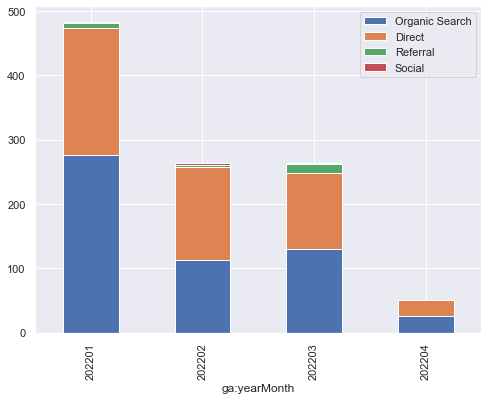

In [184]:
sns.set_theme()
sns.set(rc={'figure.figsize':(8,6)})

plot_data = report.loc[:, (slice(None), "ga:users")].iloc[:, 1:] 
plot_data.columns = plot_data.columns.get_level_values(0)
plot_data.index = plot_data.index.get_level_values(0)
plot_data.plot.bar(stacked = True);


In [169]:
plot_data


,Organic Search,Direct,Referral,Social
ga:yearMonth,,,,
202201,276.0,198.0,8.0,1.0
202202,113.0,144.0,4.0,2.0
202203,130.0,118.0,14.0,1.0
202204,25.0,26.0,0.0,0.0


In [170]:
body = body = {'reportRequests': [{'viewId': your_view_id, 
                            'dateRanges': [{'startDate': '2022-01-01', 'endDate': '2022-04-30'}],
                            'metrics': [{'expression': 'ga:sessions'},
                                        {"expression": "ga:avgSessionDuration"},
                                        {"expression": "ga:users"},
                                        {"expression": "ga:newUsers"}],
                            'dimensions': [{'name': 'ga:date'},
                                           {"name": "ga:channelGrouping"}],
                          }]}

In [171]:
report = run_report(body, ga_keys).reset_index() 
report

,ga:date,ga:channelGrouping,ga:sessions,ga:avgSessionDuration,ga:users,ga:newUsers
0,20220101,Direct,4.0,8.250000,4.0,4.0
1,20220101,Organic Search,4.0,0.000000,4.0,3.0
2,20220101,Social,1.0,0.000000,1.0,1.0
3,20220102,Direct,7.0,11.428571,7.0,7.0
4,20220102,Organic Search,3.0,0.000000,3.0,3.0
...,...,...,...,...,...,...
205,20220405,Direct,4.0,6.750000,3.0,2.0
206,20220405,Organic Search,6.0,0.000000,6.0,6.0
207,20220406,Direct,5.0,8.000000,5.0,5.0
208,20220406,Organic Search,4.0,0.000000,4.0,3.0


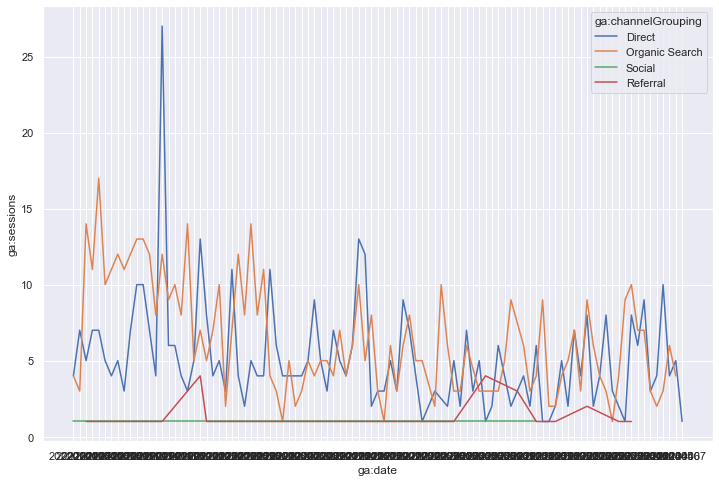

In [172]:
sns.set(rc={'figure.figsize':(12,8)})
plot_data = report.loc[:, ["ga:users"]]
sns.lineplot(data = report, y = "ga:sessions", x = 'ga:date', hue = 'ga:channelGrouping');